## Simple Kaggle submission
You may use this to test making a submission

In [627]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics

In [628]:
# Reading in data for both train.csv and test.csv

df = pd.read_csv('datasets/train.csv')
kag_test_df = pd.read_csv('datasets/test.csv')

In [629]:
df['Yr Sold'].describe()

count    2051.000000
mean     2007.775719
std         1.312014
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: Yr Sold, dtype: float64

In [630]:
df.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


## Data Cleaning & Feature Selection

In [631]:
#Snake case all columns
df.columns =[col.replace(' ', '_').lower() for col in df.columns]
kag_test_df.columns =[col.replace(' ', '_').lower() for col in kag_test_df.columns]

In [632]:
# Convert 'central_air' to binary
df['central_air'] = df['central_air'].map({'Y': 1, 'N': 0})
kag_test_df['central_air'] = kag_test_df['central_air'].map({'Y': 1, 'N': 0})

In [633]:
# Take all the numerical columns from our train set, and impute the mean for any NAN values

# Get all columns that are numerical
num_features = df.select_dtypes(include= [np.number]).columns.tolist()
num_features.remove('saleprice') # And remove saleprice from our features

# For the 'fireplaces' column, replace null values with 0
df['fireplaces'].fillna(value= 0, inplace=True)
kag_test_df['fireplaces'].fillna(value= 0, inplace=True)

# Replace null values with the median of that column
[df[feat].fillna(value= df[feat].mean(), inplace=True) for feat in num_features]
[kag_test_df[feat].fillna(value= kag_test_df[feat].mean(), inplace=True) for feat in num_features];

#### Create a column called 'qual_gr_liv_area' that will be the product of overall_qual and gr_liv_area

In [634]:
df['qual_gr_liv_area'] = df['overall_qual'] * df['gr_liv_area']

In [635]:
df.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

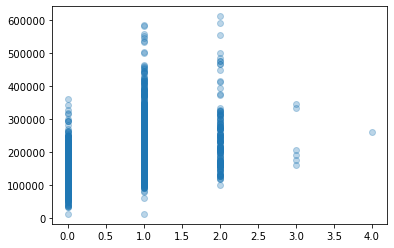

In [636]:
plt.scatter(df['fireplaces'], df['saleprice'], alpha = 0.3)

<AxesSubplot:>

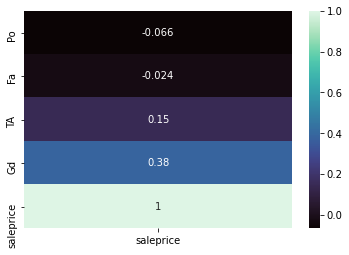

In [637]:
# Fireplace quality
fire_qu_df = pd.get_dummies(df['fireplace_qu'], drop_first = True)
fire_qu_df = fire_qu_df.merge(df['saleprice'], left_index = True, right_index = True)

# Create a correlation heatmap
#plt.figure(figsize = (8, 8))
sns.heatmap(fire_qu_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

In [638]:
fire_qu_df

,Fa,Gd,Po,TA,saleprice
0,0,0,0,0,130500
1,0,0,0,1,220000
2,0,0,0,0,109000
3,0,0,0,0,174000
4,0,0,0,0,138500
...,...,...,...,...,...
2046,0,1,0,0,298751
2047,0,0,0,0,82500
2048,0,0,0,1,177000
2049,0,1,0,0,144000


<AxesSubplot:>

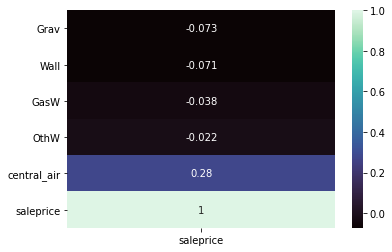

In [639]:
# Heating & Air
heat_air_df = pd.get_dummies(df['heating'], drop_first = True)
heat_air_df = heat_air_df.merge(df[['central_air', 'saleprice']], left_index = True, right_index = True)



# Create a correlation heatmap
#plt.figure(figsize = (8, 8))
sns.heatmap(heat_air_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

<AxesSubplot:xlabel='heating', ylabel='saleprice'>

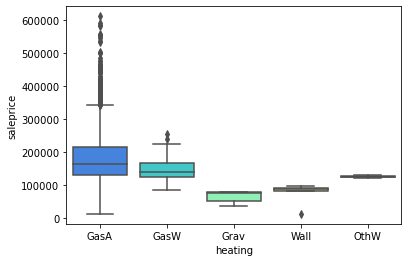

In [640]:
sns.boxplot(x= 'heating', y = 'saleprice',data = df, palette='rainbow')

<AxesSubplot:xlabel='central_air', ylabel='saleprice'>

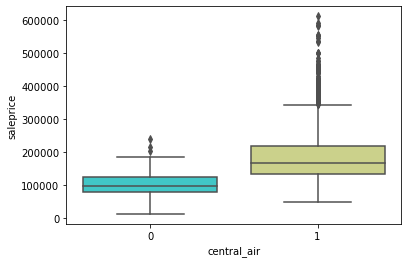

In [641]:
sns.boxplot(x= 'central_air', y = 'saleprice', data = df, palette='rainbow')

<AxesSubplot:>

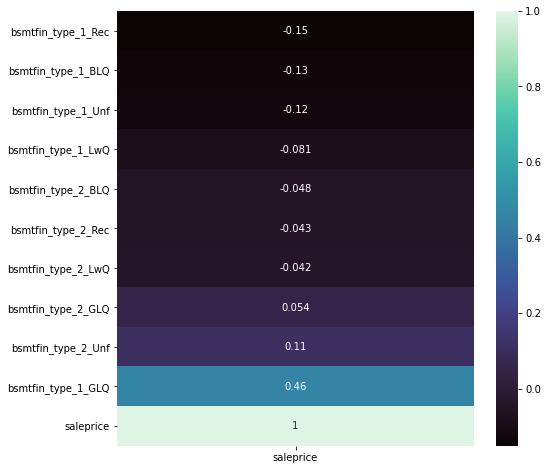

In [642]:
# Basement finish
bsmt_fin_df = pd.get_dummies(df[['bsmtfin_type_1', 'bsmtfin_type_2']], drop_first = True)
bsmt_fin_df = bsmt_fin_df.merge(df['saleprice'], left_index = True, right_index = True)

# Create a correlation heatmap
plt.figure(figsize = (8, 8))
sns.heatmap(bsmt_fin_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

<AxesSubplot:xlabel='bsmtfin_type_1', ylabel='saleprice'>

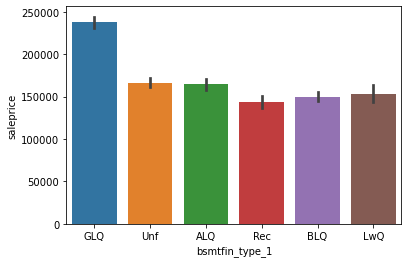

In [643]:
# Basement Finish barplot
sns.barplot(x='bsmtfin_type_1',y='saleprice',data = df)

<AxesSubplot:>

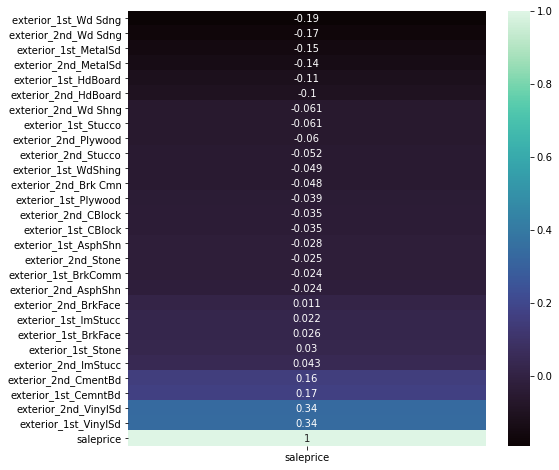

In [644]:
# Exterior siding/material
ext_df = pd.get_dummies(df[['exterior_1st', 'exterior_2nd']], drop_first = True)
ext_df = ext_df.merge(df['saleprice'], left_index = True, right_index = True)

# Create a correlation heatmap
plt.figure(figsize = (8, 8))
sns.heatmap(ext_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

<AxesSubplot:>

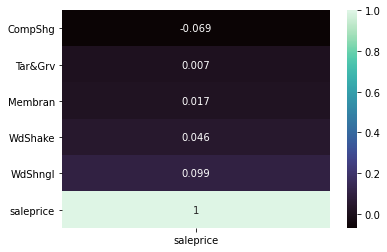

In [645]:
# Roof material
roof_df = pd.get_dummies(df['roof_matl'], drop_first = True)
roof_df = roof_df.merge(df['saleprice'], left_index = True, right_index = True)

# Condition1: Proximity to various conditions

# Condition2: Proximity to various conditions (if more than one is present)

# Create a correlation heatmap
sns.heatmap(roof_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

<AxesSubplot:>

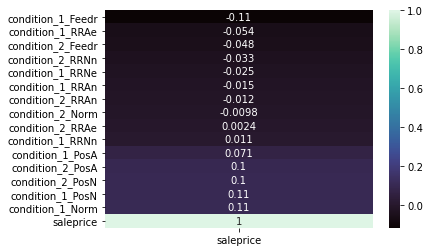

In [646]:
#Create a new df with dummy cols for proximity, and see how it correlates to saleprice

conditions_df = pd.get_dummies(df[['condition_1', 'condition_2']], drop_first = True)
conditions_df = conditions_df.merge(df['saleprice'], left_index = True, right_index = True)

# Condition1: Proximity to various conditions

# Condition2: Proximity to various conditions (if more than one is present)

# Create a correlation heatmap
sns.heatmap(conditions_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

<AxesSubplot:>

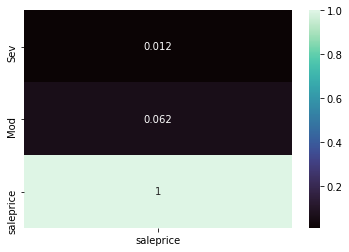

In [647]:

slope_df = pd.get_dummies(df['land_slope'], drop_first = True)
slope_df = slope_df.merge(df['saleprice'], left_index = True, right_index = True)
# Condition1: Proximity to various conditions

# Condition2: Proximity to various conditions (if more than one is present)

# Create a correlation heatmap
sns.heatmap(slope_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

<AxesSubplot:>

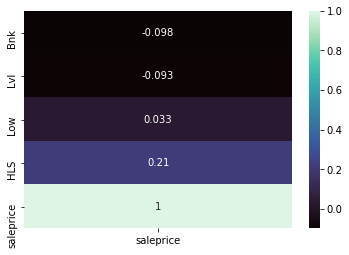

In [648]:
#Create a new df with dummy cols for proximity, and see how it correlates to saleprice

contour_df = pd.get_dummies(df['land_contour'], drop_first = False)
contour_df = contour_df.merge(df['saleprice'], left_index = True, right_index = True)
# Condition1: Proximity to various conditions

# Condition2: Proximity to various conditions (if more than one is present)

# Create a correlation heatmap
sns.heatmap(contour_df.corr()[['saleprice']].sort_values('saleprice'), annot = True, cmap = 'mako')

<AxesSubplot:>

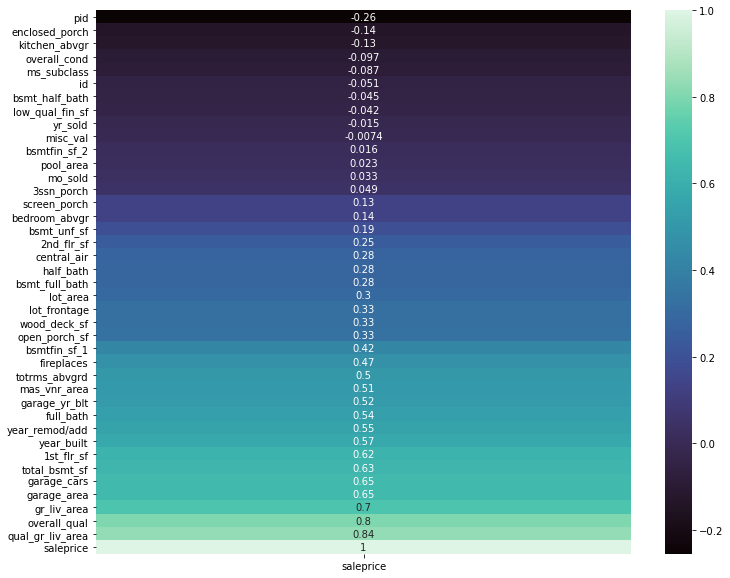

In [649]:
# Correlation heatmap
plt.figure(figsize = (12, 10))
sns.heatmap(df.corr()[['saleprice']].sort_values('saleprice'),
            annot = True,
            cmap = 'mako',
           )

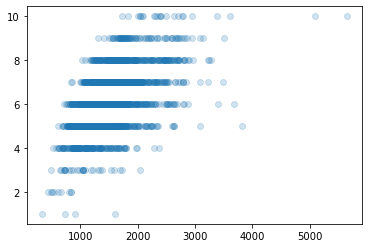

In [650]:
plt.scatter(df['gr_liv_area'], df['overall_qual'], alpha = 0.2)

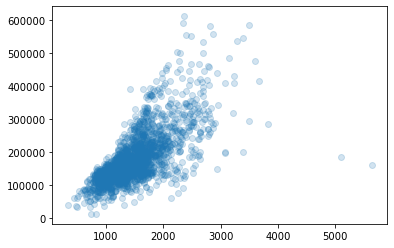

In [651]:
plt.scatter(df['gr_liv_area'], df['saleprice'], alpha = 0.2)

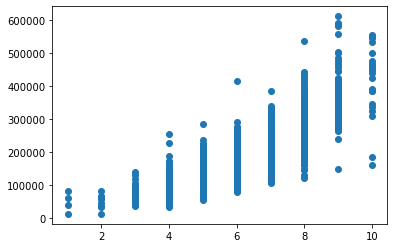

In [652]:
plt.scatter(df['overall_qual'], df['saleprice'])

In [653]:
# Categorical features to create dummy columns for
# cat_features = ['fence',  'paved_drive', '', 'heating', 
#                'bsmtfin_type_1', 'bsmtfin_type_2', 'utilities', 'ms_zoning', 'neighborhood', 'bldg_type',
#                 'house_style'
#                ]

#cat_features = ['fireplace_qu', 'bsmtfin_type_1', 'utilities', 'neighborhood' ]
cat_features = ['fireplace_qu']

# bad: 'sale_type', 'garage_qual''pool_qc', 'bsmtfin_type_2''bldg_type''ms_zoning'

In [654]:
model_df = pd.get_dummies(df[cat_features], drop_first = True)
model_df.columns = [col.replace(' ', '_').lower() for col in model_df.columns ]
model_df = pd.merge(df[num_features], model_df, left_index= True, right_index = True)


kag_model_df = pd.get_dummies(kag_test_df[cat_features], drop_first = True)
kag_model_df.columns = [col.replace(' ', '_').lower() for col in kag_model_df.columns ]
kag_model_df = pd.merge(kag_test_df[num_features], kag_model_df, left_index= True, right_index = True)

In [655]:
# If we have any columns in kag_model_df that are not in model_df, we need to drop those columns

for col in kag_model_df.columns:
    if col not in model_df.columns:
        model_df[col] = 0
        
# and if we have any columns in model_df (our training model), we need to assign 0 to those columns

for col in model_df.columns:
    if col not in kag_model_df.columns:
        kag_model_df[col] = 0

In [656]:
# Combine numeric features with categorical features
features = []
[features.append(col) for col in cat_features]
[features.append(col) for col in num_features];

## Modeling

In [657]:
X = model_df
y = df['saleprice']

In [658]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [659]:
model_df.columns

Index(['id', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'central_air', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd',
       'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area',
       'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
       'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold',
       'fireplace_qu_fa', 'fireplace_qu_gd', 'fireplace_qu_po',
       'fireplace_qu_ta'],
      dtype='object')

In [660]:
kag_model_df.columns

Index(['id', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'central_air', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd',
       'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area',
       'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
       'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold',
       'fireplace_qu_fa', 'fireplace_qu_gd', 'fireplace_qu_po',
       'fireplace_qu_ta'],
      dtype='object')

## Linear Regression

In [661]:
# instantiate and fit

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## KNN

In [662]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [663]:
knn = KNeighborsRegressor(n_neighbors = 5, weights = 'distance', p = 1)

In [664]:
cross_val_score(knn, X_train_sc, y_train).mean() #For KNN, your predictions/test values (Accuracy)

0.821845832197852

In [665]:
cross_val_score(knn, X_test_sc, y_test).mean()

0.8459360466017667

In [666]:
knn.fit(X_train_sc, y_train)

KNeighborsRegressor(p=1, weights='distance')

In [667]:
knn.score(X_train_sc, y_train)

1.0

In [668]:
knn.score(X_test_sc, y_test)

0.8688099895937338

### Predictions & metrics

In [669]:
# The predictions need to be done on the same features that we modeled on.
# Creating a variable to hold all our predictions

preds =lr.predict(kag_model_df)
train_preds =lr.predict(model_df)
train_residuals = y - train_preds

In [670]:
#R2 Score
print('R2 scores: (train/test)', lr.score(X_train, y_train), lr.score(X_test, y_test))

#Cross val score
print('Cross val scores: (train/test)', cross_val_score(lr, X_train, y_train).mean(), cross_val_score(lr, X_test, y_test).mean() )

# MSE from training data
mse = metrics.mean_squared_error(y, train_preds)
print(f'Mean squared error: (train) {mse}')

# RMSE from training data
print(f'Root mean squared error: (train) {np.sqrt(mse)}')

R2 scores: (train/test) 0.8321610198641591 0.8670197182184007
Cross val scores: (train/test) 0.7676989016010419 0.8872506726457269
Mean squared error: (train) 1000221459.888719
Root mean squared error: (train) 31626.277996133515


### Assumptions

In [671]:
# # L - Linearity
# plt.scatter(df[num_features], df["saleprice"], s=1);
#sns.pairplot(df, palette = 'cool_r');

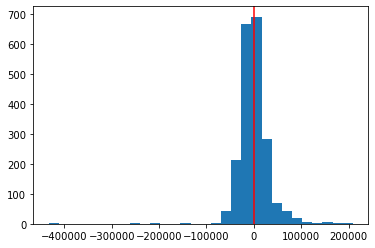

In [672]:
# N: Normality
plt.hist(train_residuals, bins = 30)
plt.axvline(x = 0, color = 'r')

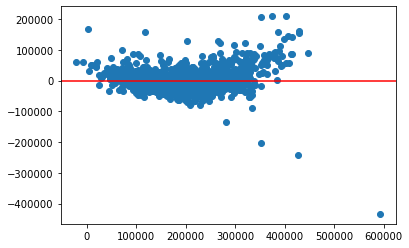

In [673]:
#E: equal variance of residuals
plt.scatter(train_preds, train_residuals)
plt.axhline(0, color = 'r')

### Create the new dataframe and csv file for submission

In [674]:
# Creating a new column that is the saleprice. These are the values from the .predict.

kag_test_df['saleprice'] = preds

In [675]:
# checking 'saleprice' is at the end

kag_test_df.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,2658,902301120,190,RM,69.000000,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,129277.551741
1,2718,905108090,90,RL,69.545961,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,151858.112933


## save out

In [676]:
# Format df for Kaggle

kaggle_submission_df = kag_test_df[['id', 'saleprice']]

In [677]:
# To csv with no index

kaggle_submission_df.to_csv('datasets/kaggle_sub6.csv', index=False)

In [678]:
kaggle_submission_df.shape

(878, 2)

### Create a function that will look at a house, and give one predicted sale price as is, and one predicted sale price with an additional home improvement.

In [679]:
# ** for a given observation, how does your model predict it's sale price both with and without a particular improvement?

In [680]:
# Take an existing observation and predict its price with and without an added feature

# What feature do we want to start with? AC?

In [681]:
# Find an observation with no AC (Later you could go back and use all with no ac)



#pd.set_option('display.max_rows', 200)
#df[df['central_air'] == 0]
#df.iloc[24]                            # <- index 24 has no ac

In [682]:
#improvement = 'central_air' - insufficient instances without AC
#improvement = 'overall_qual'
#improvement = 'full_bath'
#improvement = 'half_bath'
#improvement = 'overall_cond'

C:\Users\jgjga\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='half_bath', ylabel='saleprice'>

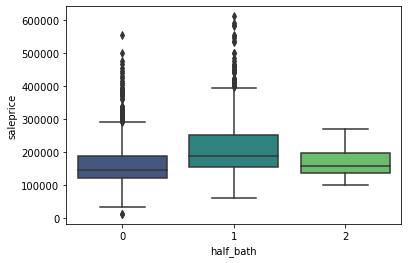

In [683]:
#sns.boxplot(x= 'heating', y = 'saleprice',data = df, palette='rainbow')
sns.boxplot(df['half_bath'], df['saleprice'], palette = 'viridis')

C:\Users\jgjga\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='full_bath', ylabel='saleprice'>

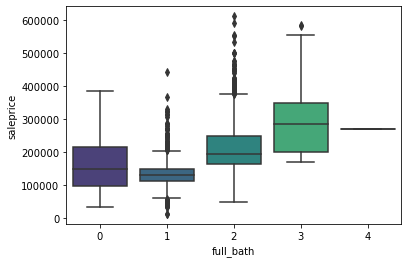

In [684]:
sns.boxplot(df['full_bath'], df['saleprice'], palette = 'viridis')

C:\Users\jgjga\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bsmt_full_bath', ylabel='saleprice'>

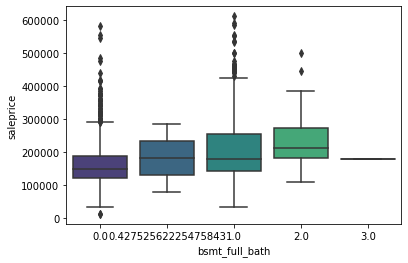

In [685]:
sns.boxplot(df['bsmt_full_bath'], df['saleprice'], palette = 'viridis')

In [686]:
# #improvement = 'central_air' - insufficient instances without AC
# #improvement = 'overall_qual'
# #improvement = 'full_bath'
# #improvement = 'half_bath'
# #improvement = 'overall_cond'
# features_df = df[num_features]

# num_features.append('saleprice')
# improvements_df = pd.DataFrame(df.iloc[[16]][num_features])
# improvements_df = improvements_df.append(improvements_df, ignore_index = True)
# num_features.remove('saleprice')

# improvements_df[improvement].iloc[0] = 1
# improvements_df[improvement].iloc[1] = improvements_df[improvement].iloc[0] + 1

# predicted_prices = lr.predict(improvements_df[num_features])
# k_preds = knn.predict(improvements_df[num_features])
# improvements_df['pred_price'] = predicted_prices
# improvement_preds_df = improvements_df[['id', improvement, 'saleprice','pred_price']]
# improvement_preds_df

In [687]:
# #improvement = 'central_air' - insufficient instances without AC
# #improvement = 'overall_qual'
improvement = 'full_bath'
# #improvement = 'half_bath'
# #improvement = 'overall_cond'



# orig df
# duplicate df = orig_df (with one feature incremented by 1)
#num_features.append('saleprice')
improved_df = model_df
#num_features.remove('saleprice')

model_df[improvement] = df[improvement]
improved_df[improvement] = improved_df[improvement] + 1


# get your predictions for orig df
orig_preds = lr.predict(model_df)
model_df['pred_price'] = orig_preds
model_df['saleprice'] = df['saleprice']

# get your predictions for duplicate_df
dupl_preds = lr.predict(improved_df)
improved_df['pred_price'] = dupl_preds
improved_df['saleprice'] = df['saleprice']

# model_df = pd.merge(df['saleprice'], model_df, left_index= True, right_index = True)
# improved_df = pd.merge(df['saleprice'], improved_df, left_index= True, right_index = True)

# the index numbers should correspond, now you can make comparisons for every row in the df
improved_df[[improvement, 'saleprice', 'pred_price']]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 43 is different from 45)

In [ ]:
model_df[[improvement, 'saleprice', 'pred_price']]

In [ ]:
# Now we need to take the mean of pred_price for both dfs

df['pred_price'].mean()


In [ ]:
improved_df['pred_price'].mean()

In [ ]:
# What % improvement is this?

improved_df['pred_price'].mean() / df['pred_price'].mean()

In [ ]:
# put all this into a function that takes a dataframe, an improvement, and the potential value for that improvement?
# How are you going to handle categoricals and dummy columns?

In [ ]:
# What do you want to do?

# set up a data frame with ONLY the features that you want and saleprice.

# Run Linear Regression and KNN on your dataframe

# for each feature you want to use in the presentation, create the new duplicate + 1 dataframe,
# and compare the two.